In [35]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
dirs = glob.glob(r'C:\Users\rampaln\OneDrive - NIWA\Research Projects\Climate_Indices\CPP_indices\notebooks\Downloads\data\*.nc')
from scipy.stats import linregress
# df = xr.open_mfdataset(list(dirs)[850:], parallel = True, combine = 'by_coords')

## Directories with ersst anomalies

In [163]:
x = []
dates = []
for file in list(dirs)[:]:
    df = xr.open_dataset(file).sel(lev =0.0, lat = slice(-40,22), lon = slice(190,253))['ssta']
    # subsetting the anomalies
    x.append(df.values)
    dates.append(file.split('\\')[-1].split('.')[2])
    # SAVING THE time metadata from the file itself. 

z1 = np.array(x)[:,0]
z1.shape


### Saving the time metadata in a separate file
dates1 =pd.to_datetime(dates, format = '%Y%m')
index_frame = pd.DataFrame(index =dates1)

index_frame['data'] = np.arange(len(index_frame))
index_frame

,data
1854-01-01,0
1854-02-01,1
1854-03-01,2
1854-04-01,3
1854-05-01,4
...,...
2019-12-01,1991
2020-01-01,1992
2020-02-01,1993
2020-03-01,1994


## Quick Visualisation of the Fields
1. Taking a random instance in time.

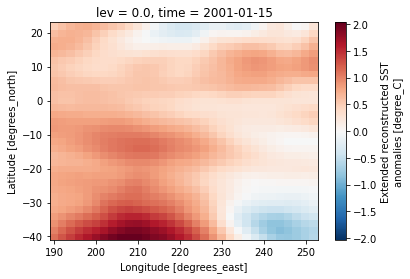

In [13]:
# plt.figure()
# plt.imshow(x[24][0], cmap='RdBu', vmin =-2, vmax =2)
# plt.colorbar()
df.isel(time =0).plot()

In [17]:
series = pd.read_excel(r"C:\Users\rampaln\OneDrive - NIWA\Research Projects\Temperature Anomalies\Copy of NZT7_Adjusted_TMean_Anomalies2020_updated.xlsx")

## Loading the NZ 7 series temperature anomalies 

In [18]:
series = series.iloc[:-1]
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec']
nums = np.arange(0,12)
d = dict()
for i in range(len(cols)):
    d[cols[i]] = nums[i]
time_series = pd.melt(series[['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
    'Oct', 'Nov', 'Dec']], id_vars =['Year'])
output =time_series['variable'].apply(lambda a: d[a])
time_series['output'] = output
time_series['datetime'] = time_series[['Year','output']].T.apply(lambda a:pd.to_datetime(f"{int(a[0])}-{int(a[1]+1)}-01") )
series = time_series.set_index(['datetime'], drop= True).sort_index()['value']

## Loading SOI index

In [15]:
df1 = pd.read_csv(r'https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/data.csv',skiprows=[0,1],header=None)
df1.index = df1[0].apply(lambda a: pd.to_datetime(a, format = "%Y%m"))#.

## Correlations with a 3-month Lag with the SOI

Correlation over 5 month rolling window 0.3944273741011614
Correlation over a 1 month rolling window 0.22298413931197972


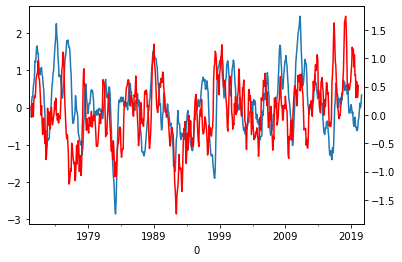

In [29]:
fig,ax = plt.subplots()
df1[1].loc["1970":].rolling(window =5).mean().plot(ax = ax)
ax2 = ax.twinx()
series.loc["1970":].rolling(window =5).mean().plot(ax = ax2, color='r')
print("Correlation over 5 month rolling window",series.loc["1970":].rolling(window =5).mean().corr(df1[1].loc["1970":].rolling(window =5).mean().shift(-3)))
print("Correlation over a 1 month rolling window",series.loc["1970":].rolling(window =1).mean().corr(df1[1].loc["1970":].rolling(window =1).mean().shift(-3)))

## Test Example with Three month  Lag in SST anomalies

In [383]:
idx = series.dropna().index.intersection(index_frame.index)
idx_samples = index_frame.loc[idx] ## Shifting the SST anomalies three months back
X = z1[idx_samples.values]
X = np.repeat(X[:,0,:,:,np.newaxis],3, axis =-1)
y = series.dropna().loc[idx]

# Detreding X
y = y - (linregress(np.arange(len(y)), y.values).slope * np.arange(len(y)) + linregress(np.arange(len(y)), y.values).intercept)

In [266]:
X[:,:,:,0].transpose(1,2,0).shape

(32, 32, 1334)

In [336]:
x1 = []
for i in range(X.shape[0]):
    x1.append(cv2.resize(X[i,:,:,0], (16,16)))
x1 = np.array(x1)
X = np.log(x1[:,:,:,np.newaxis] +7)
X = X- X.min()
X = X/X.max()* 255.0

In [337]:
X = np.repeat(X,3, axis =-1)

In [384]:
y1 = np.digitize(y, bins = np.arange(-1.5,1.5,0.1))
output = tf.keras.utils.to_categorical(
    y1, num_classes=None, dtype='float32'
)


In [385]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test =train_test_split(X,output, test_size =0.1)#X[0:2*len(X)//3],X[2*len(X)//3:], y[0:2*len(X)//3], y[2*len(X)//3:]#train_test_split(z, y, test_size =0.1)
x_test.min()


-3.6003628

In [386]:
y_train.shape

(1200, 31)

In [400]:
import tensorflow as tf
i = tf.keras.layers.Input([None, None, 3], dtype = tf.float32)
#x = tf.keras.layers.BatchNormalization()(i)
#x = tf.keras.layers.Conv2D(filters = 3, kernel_size =(3,3))(i)
# = tf.cast(x, tf.float32)
x = tf.keras.applications.resnet.preprocess_input(i)
core = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling=True,
    classes=1
)
core.trainable =False
x = core(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape((2048,))(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
#x = tf.keras.layers.Dense(16, activation = 'relu')(x)
x = tf.keras.layers.Dense(31, activation='sigmoid')(x)
model = tf.keras.Model(inputs=[i], outputs=[x])
# for layer in model.layers[3:len(model.layers)-3]:
#     layer.trainable = False


In [401]:
METRICS = [
  tf.keras.metrics.CategoricalAccuracy(name='acc'),
 keras.metrics.Precision(name='precision')]

In [406]:
core = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling=True,
    classes=31


<tf.Tensor 'conv5_block3_out_42/Identity:0' shape=(None, None, None, 2048) dtype=float32>

In [402]:
import keras.backend as K
def custom_loss(y_true, y_pred):
    abs_value = y_true - y_pred
    return K.mean(K.square(abs_value))
model.compile(loss='binary_crossentropy', optimizer ='adam',metrics = METRICS)
model.summary(

)

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_strided_slice_44 [(None, None, None, 3)]   0         
_________________________________________________________________
tf_op_layer_BiasAdd_44 (Tens [(None, None, None, 3)]   0         
_________________________________________________________________
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
batch_normalization_30 (Batc (None, None, None, 2048)  8192      
_________________________________________________________________
reshape_40 (Reshape)         (None, 2048)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)               524

In [403]:
model.fit(x_train,y_train, epochs =200, validation_data = (x_test, y_test), batch_size =32)

Train on 1200 samples, validate on 134 samples
Epoch 1/200
1200/1200 [==============================] - 12s 10ms/sample - loss: 0.2931 - acc: 0.0367 - precision: 0.0382 - val_loss: 0.1600 - val_acc: 0.0075 - val_precision: 0.0386
Epoch 2/200
1200/1200 [==============================] - 10s 9ms/sample - loss: 0.1511 - acc: 0.1008 - precision: 0.0396 - val_loss: 0.1655 - val_acc: 0.0149 - val_precision: 0.0410
Epoch 3/200
1200/1200 [==============================] - 10s 8ms/sample - loss: 0.1370 - acc: 0.1375 - precision: 0.0444 - val_loss: 0.1623 - val_acc: 0.0373 - val_precision: 0.0474
Epoch 4/200
1200/1200 [==============================] - 10s 8ms/sample - loss: 0.1322 - acc: 0.1725 - precision: 0.0523 - val_loss: 0.1720 - val_acc: 0.0373 - val_precision: 0.0558
Epoch 5/200
1200/1200 [==============================] - 10s 8ms/sample - loss: 0.1257 - acc: 0.2142 - precision: 0.0619 - val_loss: 0.1594 - val_acc: 0.0373 - val_precision: 0.0677
Epoch 6/200
1200/1200 [===================

KeyboardInterrupt: 

In [395]:
z=model.predict(x_train[:,:,:,:])
# plt.figure()
# plt.plot(np.convolve(z[:].ravel(), np.ones(1)), np.convolve(y_train[:].ravel(), np.ones(1)), 'rx')
# print(np.nanmean(abs(z.ravel()-y_train[:].ravel())**2))
# plt.figure()
# plt.plot(np.convolve(z.ravel(), np.ones(6)/6))
# plt.plot(np.convolve(y_train.ravel(), np.ones(6)/6))
# # #plt.plot(y_test[0:100

In [399]:
np.unique(np.argmax(z,axis=-1))

array([ 9, 13, 22, 30], dtype=int64)

## There appears to be an inability to produce negative outcomes with the anomalies ?

In [130]:
import tensorflow as tf
import keras
# keras = tf.keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model

input_img = keras.layers.Input(shape=(32, 32, 1)) 
x1 = keras.layers.BatchNormalization()(input_img) 
x = keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu', padding='same')(x1)
x = keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu', padding='same')(x)
#x = keras.layers.Concatenate(-1)([x,x1])


# Conv2 #
# x = keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2), padding='same')(x) 

# Conv 3 #
x = keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
encoded = keras.layers.MaxPooling2D(pool_size = (2, 2), padding='same')(x)


# x = keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
# x = keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.BatchNormalization()(x)
# encoded = keras.layers.MaxPooling2D(pool_size = (2, 2), padding='same')(x)
# ############


# x = keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
# x = keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
# x = keras.layers.BatchNormalization()(x)
# encoded = keras.layers.MaxPooling2D(pool_size = (2, 2), padding='same')(x)


#model = keras.models.Model(input_img, encoded)
#input2 = keras.layers.Input(shape=(5,32,32,1))
#distributed = keras.layers.TimeDistributed(model)(input2)


flatten = keras.layers.Flatten()(encoded)

output = keras.layers.Dense(64, activation = 'linear')(flatten)
#output = keras.layers.Dropout(0.3)(output)
decoded = keras.layers.Dense(1, activation ='relu')(output)#, kernel_initializer = 'zeros'

#decpded
# Declare the model
model = keras.models.Model(input_img,decoded)
model.output_shape
model.compile(optimizer='adam', loss='mse')
model.summary()
x_train.shape

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128 

(889, 32, 32, 3)

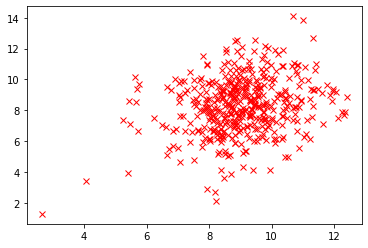

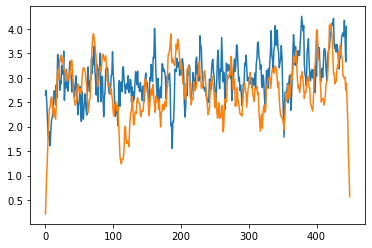

In [133]:
# model.fit(x_train[:,:,:,0:1],y_train.values, epochs =200, validation_data = (x_test[:200,:,:,0:1], y_test.values[0:200]), batch_size =10)
z=model.predict(x_test[:,:,:,0:1])
plt.plot(np.convolve(z[:].ravel(), np.ones(3)), np.convolve(y_test[:].values.ravel(), np.ones(3)), 'rx')
plt.figure()
plt.plot(z.ravel())
plt.plot(np.convolve(y_test.ravel(), np.ones(6)/6))
# #plt.plot(y_test[0:100